# Load Modules

In [19]:
# Import general pkgs
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (confusion_matrix, auc, classification_report, dcg_score, f1_score, precision_recall_curve,\
                             precision_score, recall_score, roc_auc_score, roc_curve)
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb

import pycaret
import pandas_profiling
import matplotlib.pyplot as plt
import itertools

import pickle
import joblib
import math
import os

from pygam import LogisticGAM, s, f
import warnings
warnings.filterwarnings('ignore')

In [34]:
# Eval Functions
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True, title='Normalized confusion matrix')
    plt.show()

def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    # fi to dataframe
#     df = pd.DataFrame(data=[model.feature_importances_, model.feature_name_], index=['importance','feature']).T
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df


In [2]:
# Import custom pkgs
import utils_jh
import utils_evaluation_jh

In [3]:
# Import tabnet
# pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

In [7]:
print(os.listdir('../../../data/santander/raw/'))

['test.csv', 'original_train.pickle', 'train.csv', 'original_test.pickle']


# Load Data

In [4]:
# path = '../Digitallab_Project/what_if/data/santander'
path = '../../../data/santander'
df_train = pd.read_pickle(path + '/raw/original_train.pickle')
df_test = pd.read_pickle(path + '/raw/original_test.pickle')

In [5]:
df_train.sample(3)

ID_code  target      var_0     var_1      var_2     var_3  \
16565  train_16565       0   9.679688 -2.203125  10.492188  5.960938   
38605  train_38605       0  10.546875  1.937500   9.218750  6.601562   
94635  train_94635       0  15.250000  0.842773   9.265625  7.640625   

           var_4      var_5     var_6      var_7  ...    var_190   var_191  \
16565   8.335938 -14.945312  5.113281  13.429688  ...   3.937500  3.179688   
38605   8.906250  -5.972656  5.042969  15.906250  ...  -1.191406  4.589844   
94635  12.164062   3.003906  4.988281  10.062500  ...  11.187500  3.800781   

        var_192   var_193    var_194   var_195   var_196   var_197    var_198  \
16565  0.937988  2.861328  21.734375 -1.601562  5.000000  8.742188  13.500000   
38605  4.097656  3.320312  14.703125  1.484375  7.738281  9.476562  11.203125   
94635  2.667969 -2.382812  15.390625  0.220093 -7.476562  8.250000  16.390625   

         var_199  
16565 -16.625000  
38605   6.878906  
94635  -5.757812  

[3 rows x 202 columns]

In [6]:
df_train.shape

(200000, 202)

# TabNet Modeling

## Prepare dataset for modeling

In [5]:
X = df_train.drop(['ID_code', 'target'], axis=1)
y = df_train['target']

In [6]:
# 탭넷은 넘파이 배열만 받음 (데이터프레임X)
X_np = X.to_numpy()
y_np = y.to_numpy()

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_np, y_np, test_size=0.3, random_state=777, stratify=y)
print('train : ', X_train.shape, '\t', 'test : ', X_valid.shape)

train :  (140000, 200) 	 test :  (60000, 200)


In [8]:
X_train

array([[ 12.74 ,  -0.769,   8.34 , ...,  10.37 ,  14.44 , -17.62 ],
       [  8.61 ,  -3.469,  12.94 , ...,   7.105,  17.06 ,  -8.29 ],
       [ 12.82 ,   1.622,   7.152, ...,   8.414,  13.39 ,  17.23 ],
       ...,
       [ 10.02 ,   4.75 ,  13.66 , ...,   9.82 ,  10.58 ,   6.23 ],
       [  8.24 ,  -4.75 ,  13.09 , ...,   8.9  ,  17.31 ,  -6.98 ],
       [ 11.07 ,  -6.402,   8.46 , ...,   7.32 ,  12.91 ,  -6.184]],
      dtype=float16)

In [11]:
X_valid

array([[ 10.62 ,  -6.83 ,  10.65 , ...,   9.914,  11.05 , -19.27 ],
       [ 12.75 ,  -1.727,   7.824, ...,   9.95 ,  13.46 ,   5.85 ],
       [ 12.81 ,  -2.742,  12.34 , ...,   7.977,  16.4  ,  -8.555],
       ...,
       [ 13.79 ,  -1.712,  10.87 , ...,   8.39 ,  12.68 ,   2.908],
       [  9.65 ,  -6.625,   9.59 , ...,   9.46 ,  11.92 ,   8.375],
       [  7.883,  -6.703,  10.79 , ...,   9.62 ,  10.76 ,   1.426]],
      dtype=float16)

## Train

### 1st test - no tunning

In [71]:
clf = TabNetClassifier() 
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
)

Device used : cpu
epoch 0  | loss: 0.36138 | train_auc: 0.52945 | valid_auc: 0.51962 |  0:00:32s
epoch 1  | loss: 0.31974 | train_auc: 0.62576 | valid_auc: 0.62389 |  0:01:03s
epoch 2  | loss: 0.30268 | train_auc: 0.75934 | valid_auc: 0.74979 |  0:01:35s
epoch 3  | loss: 0.26768 | train_auc: 0.83337 | valid_auc: 0.82632 |  0:02:08s
epoch 4  | loss: 0.24599 | train_auc: 0.8514  | valid_auc: 0.84347 |  0:02:41s
epoch 5  | loss: 0.24079 | train_auc: 0.85603 | valid_auc: 0.84957 |  0:03:12s
epoch 6  | loss: 0.2374  | train_auc: 0.8588  | valid_auc: 0.85244 |  0:03:43s
epoch 7  | loss: 0.23628 | train_auc: 0.85959 | valid_auc: 0.8532  |  0:04:16s
epoch 8  | loss: 0.2355  | train_auc: 0.86242 | valid_auc: 0.85476 |  0:04:48s
epoch 9  | loss: 0.23372 | train_auc: 0.86467 | valid_auc: 0.85567 |  0:05:20s
epoch 10 | loss: 0.23342 | train_auc: 0.86593 | valid_auc: 0.85633 |  0:05:52s
epoch 11 | loss: 0.23254 | train_auc: 0.86768 | valid_auc: 0.85633 |  0:06:25s
epoch 12 | loss: 0.23127 | train_a

In [73]:
joblib.dump(clf, '03_01_tabnet_model.pkl')

['03_01_tabnet_model.pkl']

In [9]:
clf = joblib.load('03_01_tabnet_model.pkl')

#### Predict

In [13]:
pred_1 = clf.predict(X_valid)

In [14]:
y_valid.sum(), pred_1.sum()

(6029, 2697)

#### Evaluation

In [15]:
y_score = pd.DataFrame(data=clf.predict_proba(X_valid)).rename({0:'y_proba_0', 1:'y_proba_1'}, axis=1)
y_true = pd.DataFrame(data=y_valid).reset_index(drop=True)
y_true = y_true.rename({y_true.columns[0]:'y_true'}, axis=1)
y_pred = pd.DataFrame(data=pred_1).rename({0:'y_pred'}, axis=1)
    
df = pd.concat([y_score, y_true, y_pred], axis=1)
df

y_proba_0  y_proba_1  y_true  y_pred
0       0.996778   0.003222       0       0
1       0.854522   0.145478       0       0
2       0.934912   0.065088       0       0
3       0.981023   0.018977       0       0
4       0.997554   0.002446       0       0
...          ...        ...     ...     ...
59995   0.950599   0.049401       0       0
59996   0.994249   0.005751       0       0
59997   0.964451   0.035549       0       0
59998   0.689319   0.310681       1       0
59999   0.795106   0.204894       0       0

[60000 rows x 4 columns]

In [50]:
# ROC_AUC
# print('AUC of Train set : ', '{:.3}'.format(roc_auc_score(df['y_true'],df_pred_tr_summary['y_proba_1'])))
print('AUC of Test  set : ', '{:.3}'.format(roc_auc_score(df['y_true'],df['y_proba_1'])))

AUC of Test  set :  0.856


In [28]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     53971
           1       0.66      0.30      0.41      6029

    accuracy                           0.91     60000
   macro avg       0.79      0.64      0.68     60000
weighted avg       0.90      0.91      0.90     60000



Confusion matrix, without normalization


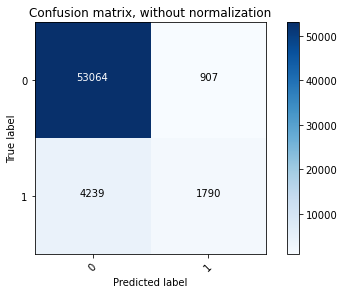

Normalized confusion matrix


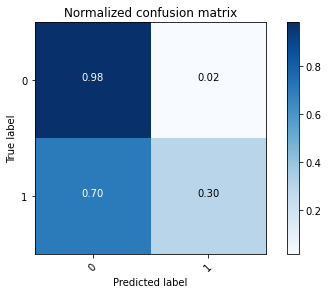

In [35]:
plot_confusion_matrix(df['y_pred'], df['y_true'])

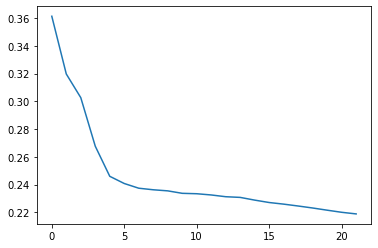

In [31]:
# plot losses
plt.plot(clf.history['loss'])

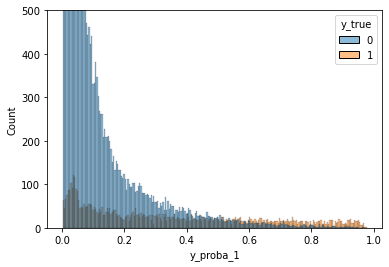

In [33]:
# Distribution of prediction
sns.histplot(data=df, x='y_proba_1', hue='y_true')
plt.ylim(0,500)
plt.show()

In [51]:
clf.feature_importances_[102]

0.24214283353359983

In [45]:
df_fi = pd.DataFrame(data=clf.feature_importances_,index=X.columns.values).reset_index()
df_fi = df_fi.rename({'index':'feature',0:'importance'},axis=1)
df_fi = df_fi.sort_values(by='importance', ascending=False)

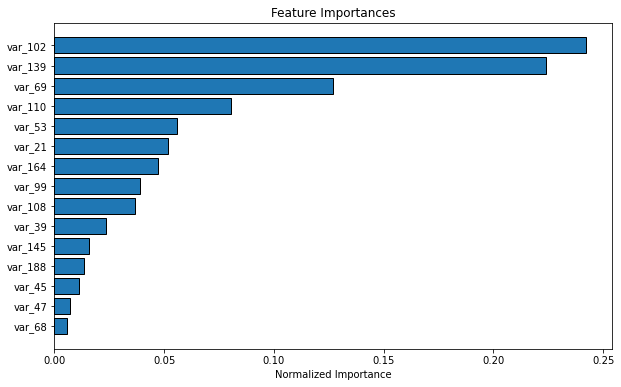

index  feature  importance  importance_normalized
0      102  var_102    0.242143               0.242143
1      139  var_139    0.224015               0.224015
2       69   var_69    0.127132               0.127132
3      110  var_110    0.080234               0.080234
4       53   var_53    0.055739               0.055739
..     ...      ...         ...                    ...
195    178  var_178    0.000000               0.000000
196      4    var_4    0.000000               0.000000
197    186  var_186    0.000000               0.000000
198    180  var_180    0.000000               0.000000
199    100  var_100    0.000000               0.000000

[200 rows x 4 columns]

In [44]:
plot_feature_importances(df_fi)

In [46]:
explain_matrix, masks = clf.explain(X_valid)

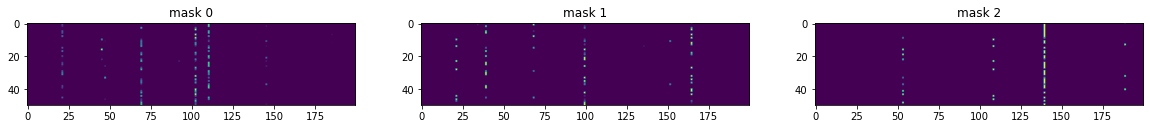

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

6029

In [57]:
clf_2 = TabNetClassifier()
clf_2.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=1000 , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)

epoch 0  | loss: 0.48842 | train_auc: 0.87104 | valid_auc: 0.85448 |  0:00:33s
epoch 1  | loss: 0.44647 | train_auc: 0.88099 | valid_auc: 0.84768 |  0:01:04s
epoch 2  | loss: 0.43034 | train_auc: 0.88957 | valid_auc: 0.84445 |  0:01:35s
epoch 3  | loss: 0.41747 | train_auc: 0.89581 | valid_auc: 0.83911 |  0:02:07s
epoch 4  | loss: 0.4058  | train_auc: 0.89632 | valid_auc: 0.83566 |  0:02:39s
epoch 5  | loss: 0.39734 | train_auc: 0.90622 | valid_auc: 0.83176 |  0:03:10s
epoch 6  | loss: 0.382   | train_auc: 0.90764 | valid_auc: 0.83236 |  0:03:44s
epoch 7  | loss: 0.38565 | train_auc: 0.90882 | valid_auc: 0.82923 |  0:04:15s
epoch 8  | loss: 0.37842 | train_auc: 0.91191 | valid_auc: 0.82973 |  0:04:48s
epoch 9  | loss: 0.3689  | train_auc: 0.91574 | valid_auc: 0.82841 |  0:05:21s
epoch 10 | loss: 0.36058 | train_auc: 0.91751 | valid_auc: 0.82548 |  0:05:54s
epoch 11 | loss: 0.35636 | train_auc: 0.91841 | valid_auc: 0.82244 |  0:06:27s
epoch 12 | loss: 0.34816 | train_auc: 0.92003 | vali

In [61]:
pred_2 = clf.predict(X_valid)

In [69]:
pred_2.sum()

19459

In [68]:
pred_1.sum()

1746